# Consolidación

In [1]:
# Importanción librerias
import sys
import os
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import missingno as msno
import re 
import warnings
import json
warnings.filterwarnings("ignore")

# Lectura tags Tactical Recipe

In [2]:
# read
tags=pd.read_excel("../../data/meta data/tags relevantes.xlsx")
tags_cc=tags.tag.to_list()
tags

,tag,description,upper bound,lower bound,unit
0,CF:CVB007_S2.PNT.FOX,granulometry,NaN,NaN,NaN
1,CF:225.WIC8067.MEAS.FOX,charge cell,NaN,NaN,NaN
2,disp_ley_pirita,pyrite law,NaN,NaN,NaN
3,disp_ley_calcopirita,chalcopyrite law,NaN,NaN,NaN
4,disp_ley_calcosina,chalcocite law,NaN,NaN,NaN
5,disp_crusher_index,crusher index,NaN,NaN,NaN
6,disp_sag_power_index,sag power index,NaN,NaN,NaN
7,disp_ball_work_index,ball work index,NaN,NaN,NaN
8,CF:215.WIC1605A.MEAS.FOX,TPH,NaN,NaN,NaN
9,CF:EXPERTO:EXP_MS_A.MEAS_5.FOX,HH TPH,NaN,NaN,NaN


In [36]:
#tags.to_excel("../meta data/tags relevantes.xlsx")

# Horizonte temporal

In [3]:
# Fechas 1min
date_format = "%Y-%m-%d %H:%M:%S"

start = datetime.strptime("2018-01-01 00:00:00", date_format )
end = datetime.strptime( "2022-09-15 23:59:00", date_format ) 
timestep = 1
time_freq = str(timestep) + 'min'
timestamps = pd.DataFrame(pd.date_range(start, end, freq=time_freq))

timestamps.rename(columns={0:"Timestamp"},
               inplace=True)
timestamps.set_index('Timestamp',inplace=True)

In [4]:
# función que entrega dataframe con tags repetidos unificados 

def smart_merge(X,Y):
    # df vacio donde s e guarda cruce de tags
    A=X.copy()
    B=Y.copy()
    df_vacio=timestamps.copy()
    
    # TAG en comun de A y B
    tags=A.columns[A.columns.isin(B.columns)]
    
    for i in tags:
        # Creación de tag en df_vacio
        df_vacio[i]=np.nan
        
        # Fechas en las cuales los datos no son nulos
        mascara_fechasA=~A[i].isnull()
        mascara_fechasB=~B[i].isnull()
        
        # Luego definimos los datos que no son nulos en df_vacio
        
        # No nulos de B
        df_vacio[i][mascara_fechasB]=B[mascara_fechasB][i]
        
        # No nulos de A, actualizando con los datos de la data X
        df_vacio[i][mascara_fechasA]=A[mascara_fechasA][i]
        
        
        
    # df con tags repetidos consolidados
    df_nutrido=df_vacio.copy()
    
    # Se eliminan los tags en comun de las tablas A y B
    A.drop(tags, 
                 axis=1,
             inplace=True)
     
    B.drop(tags, 
                 axis=1,
             inplace=True)
    # 1er merge sin los tags repetidos de cada tabla
    mg1=A.merge(B, left_index=True, right_index=True,how='outer',suffixes=('_x', '_y'))

    # Merge  con los tags repetidos unificados
    df_merge=mg1.merge(df_nutrido, left_index=True, right_index=True,how='outer',suffixes=('_x', '_y'))
    return df_merge

# APC comments (Estado del sistema de control)

In [5]:
# Listado de archivos
dir = '../../data/raw data/APC comments/'
contenido = os.listdir(dir)
ubicacion=[]
for fichero in contenido:
    ubicacion.append(dir+fichero)
ubicacion

['../../data/raw data/APC comments/APC Comments 2020.xlsx',
 '../../data/raw data/APC comments/APC Comments 2021.xlsx',
 '../../data/raw data/APC comments/APC Comments 2022.xlsx']

In [6]:
# Lectura
list_df=[]
for i in ubicacion:
    df=pd.read_excel(i,header=2,sheet_name="Sheet1",usecols='A:R')
    df=df.rename(columns={'Unnamed: 0':'Timestamp', 0.0006944444444444444:'Time 2'}).drop(columns='Time 2').set_index('Timestamp')
    df.index=pd.to_datetime(df.index) 
    df.index=df.index.round('S')
    col=[df.columns[0]]
    for i in df.columns[1:]:
        col.append(re.search('"(.*)"', i).group(1))
    df.columns=col
    list_df.append(df)

In [7]:
df_apc_comments= pd.concat(list_df, axis=0)
df_apc_comments.reset_index(inplace=True)
df_apc_comments.drop_duplicates(subset=["Timestamp"],inplace=True,keep='first')
df_apc_comments.set_index("Timestamp",inplace=True)
df_apc_comments.resample("1min").apply(np.nanmean)
df_apc_comments.head()

,CF:EXPERTO.HAB_EXP.CO_1.FOX,Limitado por Límite Alto de Tonelaje,Optimizando tonelaje,Limitado por Peso,Limitado por Corriente Bobina,Limitado por torque espesador 2,Limitado por torque espesador 3,Limitado por Potencia Bolas 1,Limitado por Potencia Bolas 2,Limitado por Pebbles,Limitado por Corriente harnero,Limitado por Potencia SAG,Limitado por limite bajo de tonelaje,Limitado por Temperatura bobina,Limitado por presión espesador 2,Limitado por presión espesador 3
Timestamp,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2020-01-01 00:01:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2020-01-01 00:02:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2020-01-01 00:03:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2020-01-01 00:04:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0


In [8]:
for i in df_apc_comments.columns:
    df_apc_comments[i]=df_apc_comments[i].apply(lambda x: 1 if x!=0 else 0)

In [9]:
# Merge con rango de fechas
df_apc_comments = timestamps.merge(df_apc_comments, left_index=True, right_index=True,how='left')
df_apc_comments.head()

,CF:EXPERTO.HAB_EXP.CO_1.FOX,Limitado por Límite Alto de Tonelaje,Optimizando tonelaje,Limitado por Peso,Limitado por Corriente Bobina,Limitado por torque espesador 2,Limitado por torque espesador 3,Limitado por Potencia Bolas 1,Limitado por Potencia Bolas 2,Limitado por Pebbles,Limitado por Corriente harnero,Limitado por Potencia SAG,Limitado por limite bajo de tonelaje,Limitado por Temperatura bobina,Limitado por presión espesador 2,Limitado por presión espesador 3
Timestamp,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Se guarda en csv
df_apc_comments.to_csv('../../data/consolidated data/APC_comments'+pd.to_datetime('today').strftime('%d%B%Y')+'.csv', index=True)

In [12]:
# Se lee csv
df_apc_comments=pd.read_csv('../../data/consolidated data/APC_comments15December2022.csv', parse_dates=['Timestamp'], index_col='Timestamp')
df_apc_comments.head()

,CF:EXPERTO.HAB_EXP.CO_1.FOX,Limitado por Límite Alto de Tonelaje,Optimizando tonelaje,Limitado por Peso,Limitado por Corriente Bobina,Limitado por torque espesador 2,Limitado por torque espesador 3,Limitado por Potencia Bolas 1,Limitado por Potencia Bolas 2,Limitado por Pebbles,Limitado por Corriente harnero,Limitado por Potencia SAG,Limitado por limite bajo de tonelaje,Limitado por Temperatura bobina,Limitado por presión espesador 2,Limitado por presión espesador 3
Timestamp,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_apc_comments.describe()

,CF:EXPERTO.HAB_EXP.CO_1.FOX,Limitado por Límite Alto de Tonelaje,Optimizando tonelaje,Limitado por Peso,Limitado por Corriente Bobina,Limitado por torque espesador 2,Limitado por torque espesador 3,Limitado por Potencia Bolas 1,Limitado por Potencia Bolas 2,Limitado por Pebbles,Limitado por Corriente harnero,Limitado por Potencia SAG,Limitado por limite bajo de tonelaje,Limitado por Temperatura bobina,Limitado por presión espesador 2,Limitado por presión espesador 3
count,1.139040e+06,1.139040e+06,1.139040e+06,1.139040e+06,1.139040e+06,1.139040e+06,1.139040e+06,1.139040e+06,1.139040e+06,1.139040e+06,1.139040e+06,1.139040e+06,1139040.0,1139040.0,1.139040e+06,1.139040e+06
mean,8.612367e-01,7.544265e-01,1.620057e-01,1.449001e-01,5.043721e-03,8.454488e-04,4.784731e-04,2.765487e-04,7.699466e-04,7.774090e-03,2.651356e-04,2.905956e-04,0.0,0.0,1.009622e-04,4.214075e-05
std,3.456996e-01,4.304269e-01,3.684562e-01,3.520002e-01,7.083986e-02,2.906432e-02,2.186880e-02,1.662746e-02,2.773724e-02,8.782745e-02,1.628083e-02,1.704439e-02,0.0,0.0,1.004749e-02,6.491457e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00
50%,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,0.0,1.000000e+00,1.000000e+00


<AxesSubplot:>

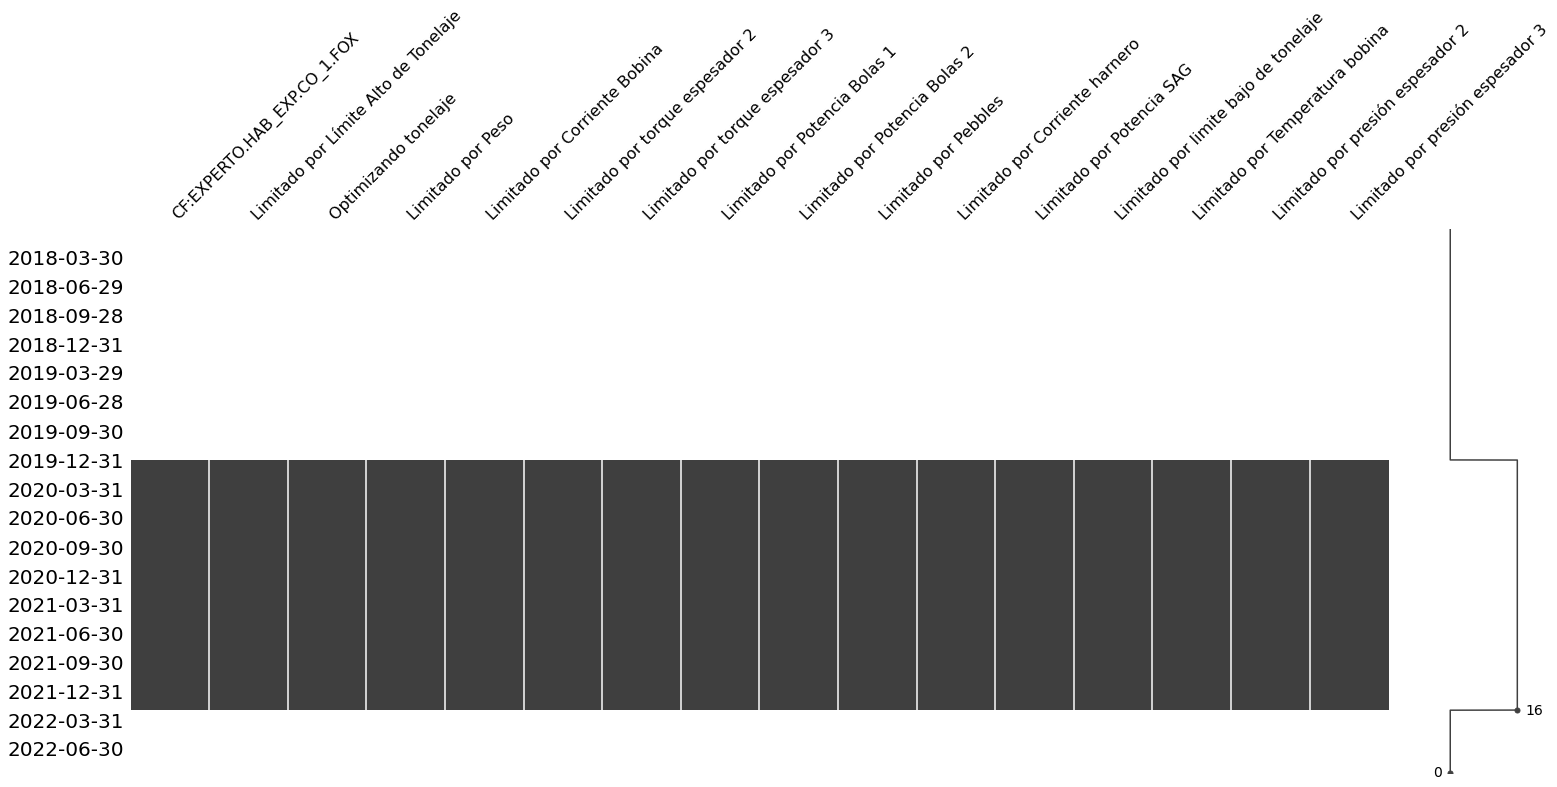

In [14]:
# Missings
msno.matrix(df_apc_comments,freq="BQ")

# APC

In [16]:
# Listado de archivos
dir = '../../data/raw data/APC/'
contenido = os.listdir(dir)
ubicacion=[]
for fichero in contenido:
    ubicacion.append(dir+fichero)
ubicacion

['../../data/raw data/APC/APC 2020 01 1-2.xlsx',
 '../../data/raw data/APC/APC 2020 01 2-2.xlsx',
 '../../data/raw data/APC/APC 2020 02 1-2.xlsx',
 '../../data/raw data/APC/APC 2020 02 2-2.xlsx',
 '../../data/raw data/APC/APC 2020 03 1-2.xlsx',
 '../../data/raw data/APC/APC 2020 03 2-2.xlsx',
 '../../data/raw data/APC/APC 2020 04 1-2.xlsx',
 '../../data/raw data/APC/APC 2020 04 2-2.xlsx',
 '../../data/raw data/APC/APC 2020 05 1-2.xlsx',
 '../../data/raw data/APC/APC 2020 05 2-2.xlsx',
 '../../data/raw data/APC/APC 2020 06 1-2.xlsx',
 '../../data/raw data/APC/APC 2020 06 2-2.xlsx',
 '../../data/raw data/APC/APC 2020 07 1-2.xlsx',
 '../../data/raw data/APC/APC 2020 07 2-2.xlsx',
 '../../data/raw data/APC/APC 2020 08 1-2.xlsx',
 '../../data/raw data/APC/APC 2020 08 2-2.xlsx',
 '../../data/raw data/APC/APC 2020 09 1-2.xlsx',
 '../../data/raw data/APC/APC 2020 09 2-2.xlsx',
 '../../data/raw data/APC/APC 2020 10 1-2.xlsx',
 '../../data/raw data/APC/APC 2020 10 2-2.xlsx',
 '../../data/raw dat

In [17]:
# Lectura
list_df=[]
for i in ubicacion:
    print(i)
    df=pd.read_excel(i,sheet_name="Sheet2")

    try:
        df.rename(columns={"Unnamed: 0":"Timestamp"},
                inplace=True)
        
        df.drop([0.0006944444444444444], 
                axis=1,
            inplace=True)
    except:
        pass

    # Seteo de indice
    df.set_index('Timestamp',inplace=True)

    # Tags a utilizar
    usar=df.columns[df.columns.isin(tags_cc)]
 
    # Reduccion tags
    df=df[usar]
    list_df.append(df)


../../data/raw data/APC/APC 2020 01 1-2.xlsx
../../data/raw data/APC/APC 2020 01 2-2.xlsx
../../data/raw data/APC/APC 2020 02 1-2.xlsx
../../data/raw data/APC/APC 2020 02 2-2.xlsx
../../data/raw data/APC/APC 2020 03 1-2.xlsx
../../data/raw data/APC/APC 2020 03 2-2.xlsx
../../data/raw data/APC/APC 2020 04 1-2.xlsx
../../data/raw data/APC/APC 2020 04 2-2.xlsx
../../data/raw data/APC/APC 2020 05 1-2.xlsx
../../data/raw data/APC/APC 2020 05 2-2.xlsx
../../data/raw data/APC/APC 2020 06 1-2.xlsx
../../data/raw data/APC/APC 2020 06 2-2.xlsx
../../data/raw data/APC/APC 2020 07 1-2.xlsx
../../data/raw data/APC/APC 2020 07 2-2.xlsx
../../data/raw data/APC/APC 2020 08 1-2.xlsx
../../data/raw data/APC/APC 2020 08 2-2.xlsx
../../data/raw data/APC/APC 2020 09 1-2.xlsx
../../data/raw data/APC/APC 2020 09 2-2.xlsx
../../data/raw data/APC/APC 2020 10 1-2.xlsx
../../data/raw data/APC/APC 2020 10 2-2.xlsx
../../data/raw data/APC/APC 2020 11.xlsx
../../data/raw data/APC/APC 2020 12.xlsx
../../data/raw dat

In [18]:
# Unificación APC
df_apc = pd.concat(list_df, 
                   axis=0)
df_apc.index=pd.to_datetime(df_apc.index) 
df_apc.index=df_apc.index.round('S')
df_apc.reset_index(drop=False,inplace=True)
df_apc.drop_duplicates(subset=["Timestamp"],inplace=True,keep='first')
df_apc.set_index('Timestamp',inplace=True)
# Cambio de formato de tags
for i in df_apc.columns:
    df_apc[i]=pd.to_numeric(df_apc[i], errors='coerce')

# Merge con rango de fechas
df_apc = timestamps.merge(df_apc, left_index=True, right_index=True,how='left')
df_apc.head()

,CF:225.OI8162.PNT.FOX,CF:CVB007_S2.PNT.FOX,CF:225.WIC8067.MEAS.FOX,CF:EXPERTO:EXP_MS_A.MEAS_1.FOX,CF:EXPERTO:EXP_MS_A.MEAS_7.FOX,CF:225.JI8161.PNT.FOX,CF:225.II8163.PNT.FOX,CF:215.WIC1605A.MEAS.FOX,CF:EXPERTO:EXP_MS_A.MEAS_5.FOX,CF:215.PORC_SOLD.PNT.FOX,CF:225:FIC1701CA_RI02.FOX,CF:225.FIC1701.MEAS.FOX,CF:225.SI8160.PNT.FOX
Timestamp,,,,,,,,,,,,,
2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Se guarda en csv
df_apc.to_csv('../../data/consolidated data/APC_'+pd.to_datetime('today').strftime('%d%B%Y')+'.csv', index=True)

In [20]:
# Se lee csv
df_apc=pd.read_csv('../../data/consolidated data/APC_15December2022.csv', parse_dates=['Timestamp'], index_col='Timestamp')
df_apc.head()

,CF:225.OI8162.PNT.FOX,CF:CVB007_S2.PNT.FOX,CF:225.WIC8067.MEAS.FOX,CF:EXPERTO:EXP_MS_A.MEAS_1.FOX,CF:EXPERTO:EXP_MS_A.MEAS_7.FOX,CF:225.JI8161.PNT.FOX,CF:225.II8163.PNT.FOX,CF:215.WIC1605A.MEAS.FOX,CF:EXPERTO:EXP_MS_A.MEAS_5.FOX,CF:215.PORC_SOLD.PNT.FOX,CF:225:FIC1701CA_RI02.FOX,CF:225.FIC1701.MEAS.FOX,CF:225.SI8160.PNT.FOX
Timestamp,,,,,,,,,,,,,
2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

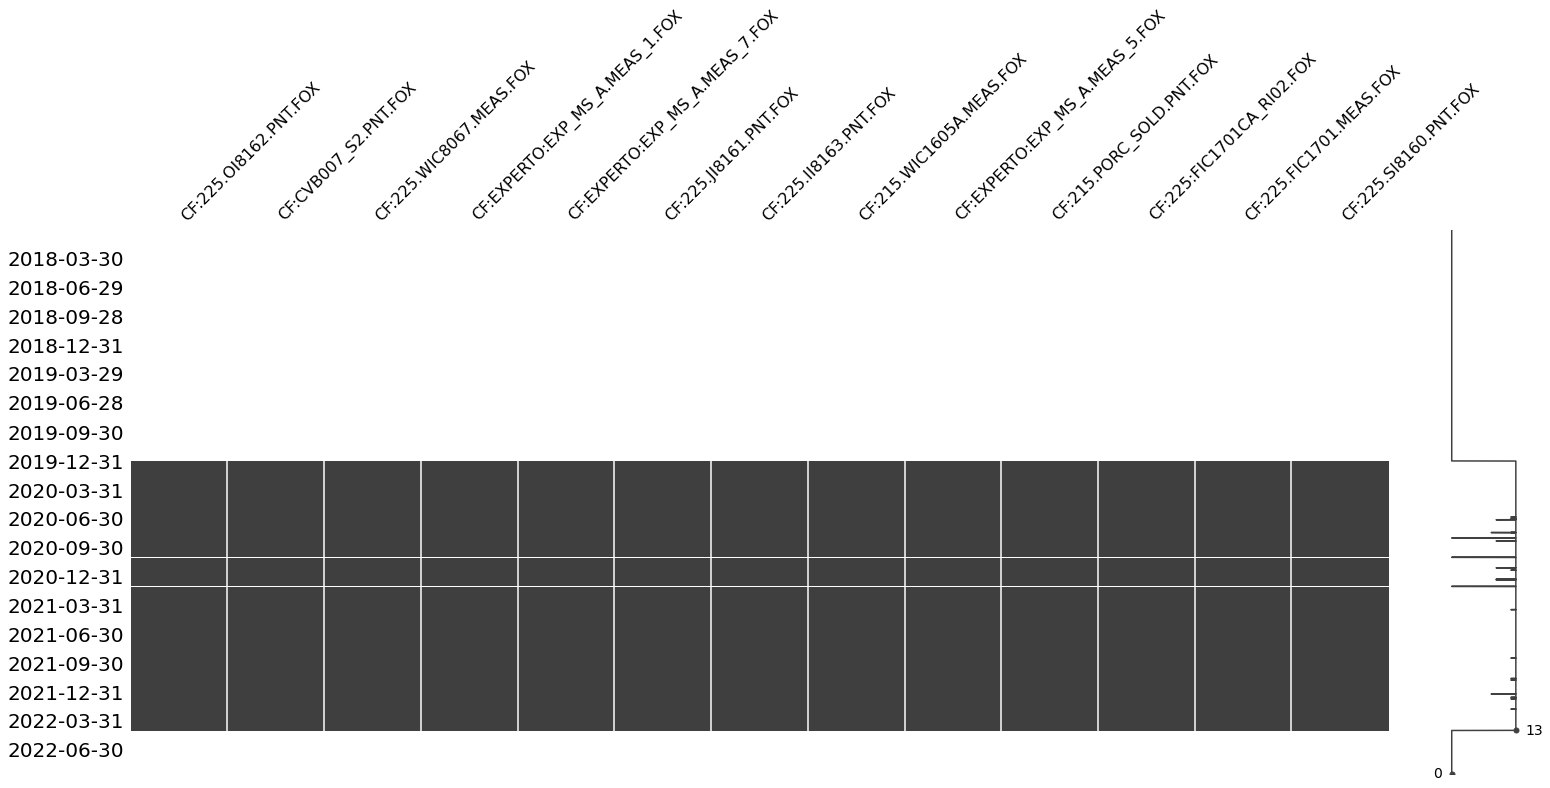

In [21]:
# Missings
msno.matrix(df_apc,freq='BQ')

# Granulometría

In [22]:
df_granulometria=pd.read_csv("../../data/raw data/F80/Indices_Granulometria.csv",index_col="Time 1", parse_dates=["Time 1"])
df_granulometria.index.names=["Timestamp"]
# Merge con rango de fechas
df_granulometria = timestamps.merge(df_granulometria, left_index=True, right_index=True,how='left')
df_granulometria.head()

,CF:CVB007_S2.PNT.FOX
Timestamp,
2018-01-01 00:00:00,NaN
2018-01-01 00:01:00,NaN
2018-01-01 00:02:00,NaN
2018-01-01 00:03:00,NaN
2018-01-01 00:04:00,NaN


<AxesSubplot:>

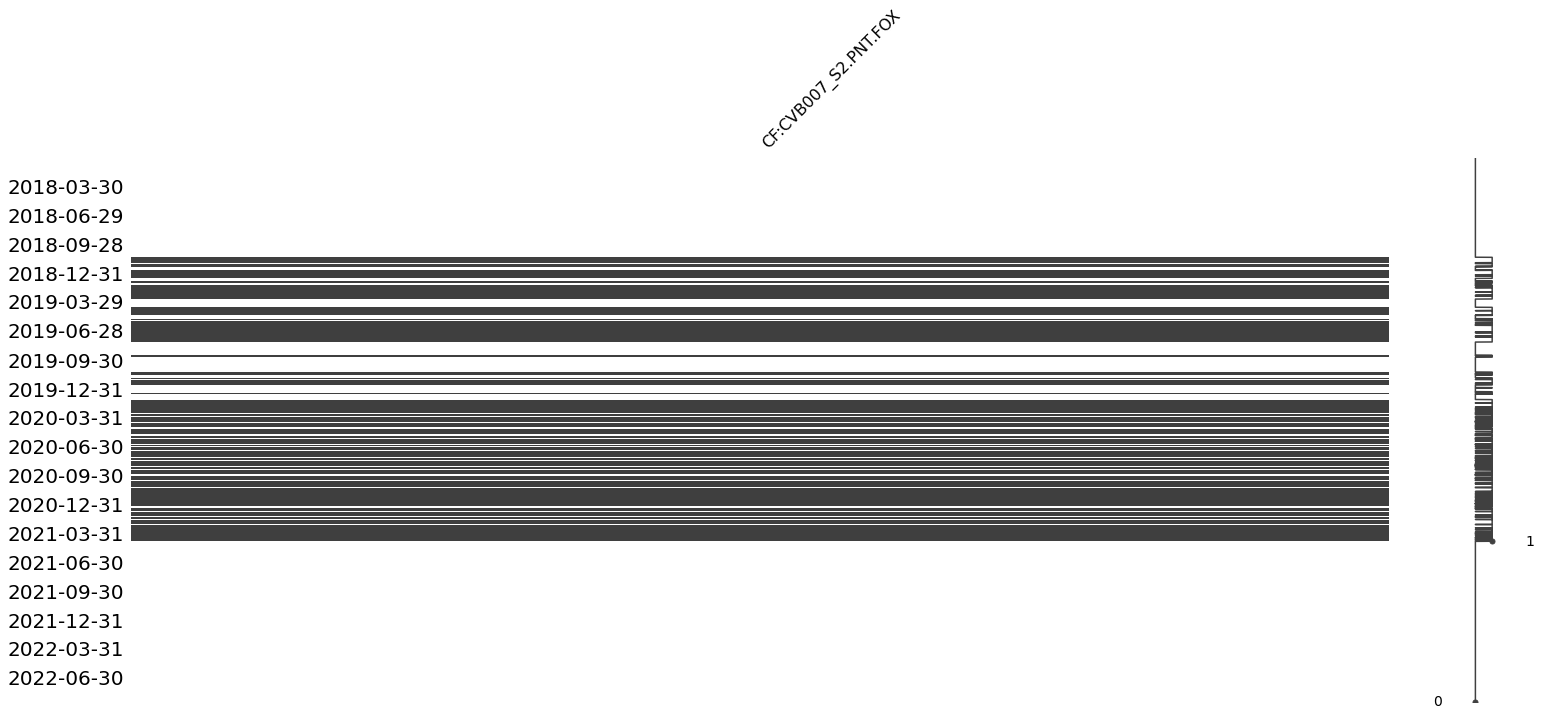

In [23]:
# Missings
msno.matrix(df_granulometria,freq='BQ')

<AxesSubplot:xlabel='Timestamp'>

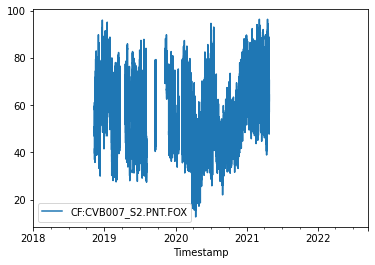

In [24]:
df_granulometria.plot()

# Dispatch

In [25]:
# Listado de archivos
dir = '../../data/raw data/Dispatch/'
contenido = os.listdir(dir)
ubicacion=[]
for fichero in contenido:
    ubicacion.append(dir+fichero)
ubicacion

['../../data/raw data/Dispatch/plant_performance_export_26.02.21.xlsx']

In [26]:
# Lectura
list_df=[]
for i in ubicacion:
    print(i)
    df=pd.read_excel(i,sheet_name="data",header=0)
    df=df[df["crusher"]=="PRIM DOS"]
    try:
        df.rename(columns={"time":"Timestamp"},
                inplace=True)    
    except:
        pass
    
    #Seteo de indice
    df.set_index('Timestamp',inplace=True)
    df.sort_index(inplace=True)
    # Tags a utilizar
    usar=df.columns[df.columns.isin(tags_cc)]

    # Reduccion tags
    df=df[usar]
    list_df.append(df)
    

../../data/raw data/Dispatch/plant_performance_export_26.02.21.xlsx


In [27]:
# Listado de archivos
dir = '../../data/raw data/Dispatch 2/'
contenido = os.listdir(dir)
ubicacion=[]
for fichero in contenido:
    ubicacion.append(dir+fichero)
ubicacion

['../../data/raw data/Dispatch 2/Crushertoplant_1h_2021.xlsx',
 '../../data/raw data/Dispatch 2/Crushertoplant_1h_2022.xlsx']

In [28]:
for i in ubicacion:
    print(i)
    df=pd.read_excel(i,header=0)
    df = df[df['line_id']==102]
    
    try:
        df.rename(columns={"time":"Timestamp"},
                inplace=True)    
    except:
        pass
    
    #Seteo de indice
    df.set_index('Timestamp',inplace=True)
    df.sort_index(inplace=True)
    # Tags a utilizar
    usar=df.columns[df.columns.isin(tags_cc)]

    # Reduccion tags
    df=df[usar]
    # Correccion de porcentajes
    for i in ['disp_ley_calcopirita', 
            'disp_ley_pirita', 
            'disp_ley_calcosina',
            'disp_ley_bornita',
            'disp_ley_covelina',]:
        df[i] = 100*df[i]

    list_df.append(df)

../../data/raw data/Dispatch 2/Crushertoplant_1h_2021.xlsx
../../data/raw data/Dispatch 2/Crushertoplant_1h_2022.xlsx


In [29]:
# Unificación dispatch
df_dispatch = pd.concat(list_df, 
                   axis=0)
df_dispatch.index=pd.to_datetime(df_dispatch.index) 
df_dispatch.index=df_dispatch.index.round('S')
df_dispatch.reset_index(drop=False,inplace=True)
df_dispatch.drop_duplicates(subset=["Timestamp"],inplace=True,keep='first')
df_dispatch.set_index('Timestamp',inplace=True)
# Cambio de formato de tags
for i in df_dispatch.columns:
    df_dispatch[i]=pd.to_numeric(df_dispatch[i], errors='coerce')

# Merge con rango de fechas
df_dispatch = timestamps.merge(df_dispatch, left_index=True, right_index=True,how='left')
df_dispatch.sort_index(inplace=True)
df_dispatch.fillna(method='ffill',limit=59,inplace=True)
df_dispatch.index=df_dispatch.index+timedelta(hours=2)
df_dispatch.head()

,disp_ley_pirita,disp_ley_calcopirita,disp_ley_calcosina,disp_ley_covelina,disp_crusher_index,disp_sag_power_index,disp_ball_work_index,disp_ley_bornita
Timestamp,,,,,,,,
2018-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## SAG Mill Scaner

In [30]:
# Listado de archivos
dir = '../../data/raw data/SAG mill Scanner/'
contenido = os.listdir(dir)
ubicacion=[]
for fichero in contenido:
    ubicacion.append(dir+fichero)
ubicacion

['../../data/raw data/SAG mill Scanner/Data Millscaner.xlsx',
 '../../data/raw data/SAG mill Scanner/Mill Scaner - abr-Jun 2021 (1).xlsx',
 '../../data/raw data/SAG mill Scanner/SAG Mill scaner 2018 1.xlsx',
 '../../data/raw data/SAG mill Scanner/SAG Mill scaner 2018 2.xlsx',
 '../../data/raw data/SAG mill Scanner/SAG Mill scaner 2018 3.xlsx',
 '../../data/raw data/SAG mill Scanner/SAG Mill scaner 2019 1.xlsx',
 '../../data/raw data/SAG mill Scanner/SAG Mill scaner 2019 2.xlsx',
 '../../data/raw data/SAG mill Scanner/SAG Mill scaner 2019 3.xlsx',
 '../../data/raw data/SAG mill Scanner/SAG Mill scaner 2021 1.xlsx',
 '../../data/raw data/SAG mill Scanner/SAG Mill scaner.xlsx']

In [31]:
# Lectura
list_df=[]
for i in ubicacion:
    print(i)
   
    df=pd.read_excel(i,header=0)
 
    try:
        df.rename(columns={"Unnamed: 0":"Timestamp"},
                inplace=True)    
    except:
        pass
    
    #Seteo de indice
    df.set_index('Timestamp',inplace=True)

    # Tags a utilizar
    usar=df.columns[df.columns.isin(tags_cc)]

    # Reduccion tags
    df=df[usar]
    list_df.append(df)

../../data/raw data/SAG mill Scanner/Data Millscaner.xlsx
../../data/raw data/SAG mill Scanner/Mill Scaner - abr-Jun 2021 (1).xlsx
../../data/raw data/SAG mill Scanner/SAG Mill scaner 2018 1.xlsx
../../data/raw data/SAG mill Scanner/SAG Mill scaner 2018 2.xlsx
../../data/raw data/SAG mill Scanner/SAG Mill scaner 2018 3.xlsx
../../data/raw data/SAG mill Scanner/SAG Mill scaner 2019 1.xlsx
../../data/raw data/SAG mill Scanner/SAG Mill scaner 2019 2.xlsx
../../data/raw data/SAG mill Scanner/SAG Mill scaner 2019 3.xlsx
../../data/raw data/SAG mill Scanner/SAG Mill scaner 2021 1.xlsx
../../data/raw data/SAG mill Scanner/SAG Mill scaner.xlsx


In [32]:
# Unificación SAG mill scanner
df_SAG = pd.concat(list_df, 
                   axis=0)
df_SAG.index=pd.to_datetime(df_SAG.index) 
df_SAG.index=df_SAG.index.round('S')
df_SAG.reset_index(drop=False,inplace=True)
df_SAG.drop_duplicates(subset=["Timestamp"],inplace=True,keep='first')
df_SAG.set_index('Timestamp',inplace=True)
# Cambio de formato de tags
for i in df_SAG.columns:
    df_SAG[i]=pd.to_numeric(df_SAG[i], errors='coerce')

# Merge con rango de fechas
df_SAG = timestamps.merge(df_SAG, left_index=True, right_index=True,how='left')
df_SAG.head()

,CF:225.OI8162.PNT.FOX,CF:CVB007_S2.PNT.FOX,CF:225.WIC8067.MEAS.FOX,CF:225.JI8161.PNT.FOX,CF:215.WIC1605A.MEAS.FOX,CF:215.PORC_SOLD.PNT.FOX,CF:225.FIC1701.MEAS.FOX,CF:225.SI8160.PNT.FOX,CF:225:FIC1701CA_RI02.FOX,CF:EXPERTO:EXP_MS_A.MEAS_1.FOX,CF:EXPERTO:EXP_MS_A.MEAS_7.FOX,CF:EXPERTO:EXP_MS_A.MEAS_5.FOX,CF:225.II8163.PNT.FOX
Timestamp,,,,,,,,,,,,,
2018-01-01 00:00:00,67.499208,63.702719,864.295848,23071.203516,3847.009774,65.090716,2063.724810,9.063008,65.0,820.0,900.0,4350.0,3935.520368
2018-01-01 00:01:00,67.410009,62.920996,862.125504,23043.030173,3872.996001,65.171210,2072.257994,9.062102,65.0,820.0,900.0,4350.0,3930.839200
2018-01-01 00:02:00,67.261466,62.847943,859.956386,22991.287211,3879.211149,65.122192,2079.820066,9.062520,65.0,820.0,900.0,4350.0,3923.503230
2018-01-01 00:03:00,67.115891,63.369101,858.914758,22943.243462,3894.792946,65.085609,2089.536865,9.062208,65.0,820.0,900.0,4350.0,3914.689267
2018-01-01 00:04:00,67.054172,63.409187,857.932221,22921.665087,3959.416847,65.271563,2110.715057,9.062822,65.0,820.0,900.0,4350.0,3910.292390


In [33]:
# Se guarda en csv
df_SAG.to_csv('../../data/consolidated data/mill_scanner_'+pd.to_datetime('today').strftime('%d%B%Y')+'.csv', index=True)

In [34]:
# Se lee csv
df_SAG=pd.read_csv('../../data/consolidated data/mill_scanner_15December2022.csv', parse_dates=['Timestamp'], index_col='Timestamp')
df_SAG.head()

,CF:225.OI8162.PNT.FOX,CF:CVB007_S2.PNT.FOX,CF:225.WIC8067.MEAS.FOX,CF:225.JI8161.PNT.FOX,CF:215.WIC1605A.MEAS.FOX,CF:215.PORC_SOLD.PNT.FOX,CF:225.FIC1701.MEAS.FOX,CF:225.SI8160.PNT.FOX,CF:225:FIC1701CA_RI02.FOX,CF:EXPERTO:EXP_MS_A.MEAS_1.FOX,CF:EXPERTO:EXP_MS_A.MEAS_7.FOX,CF:EXPERTO:EXP_MS_A.MEAS_5.FOX,CF:225.II8163.PNT.FOX
Timestamp,,,,,,,,,,,,,
2018-01-01 00:00:00,67.499208,63.702719,864.295848,23071.203516,3847.009774,65.090716,2063.724810,9.063008,65.0,820.0,900.0,4350.0,3935.520368
2018-01-01 00:01:00,67.410009,62.920996,862.125504,23043.030173,3872.996001,65.171210,2072.257994,9.062102,65.0,820.0,900.0,4350.0,3930.839200
2018-01-01 00:02:00,67.261466,62.847943,859.956386,22991.287211,3879.211149,65.122192,2079.820066,9.062520,65.0,820.0,900.0,4350.0,3923.503230
2018-01-01 00:03:00,67.115891,63.369101,858.914758,22943.243462,3894.792946,65.085609,2089.536865,9.062208,65.0,820.0,900.0,4350.0,3914.689267
2018-01-01 00:04:00,67.054172,63.409187,857.932221,22921.665087,3959.416847,65.271563,2110.715057,9.062822,65.0,820.0,900.0,4350.0,3910.292390


<AxesSubplot:>

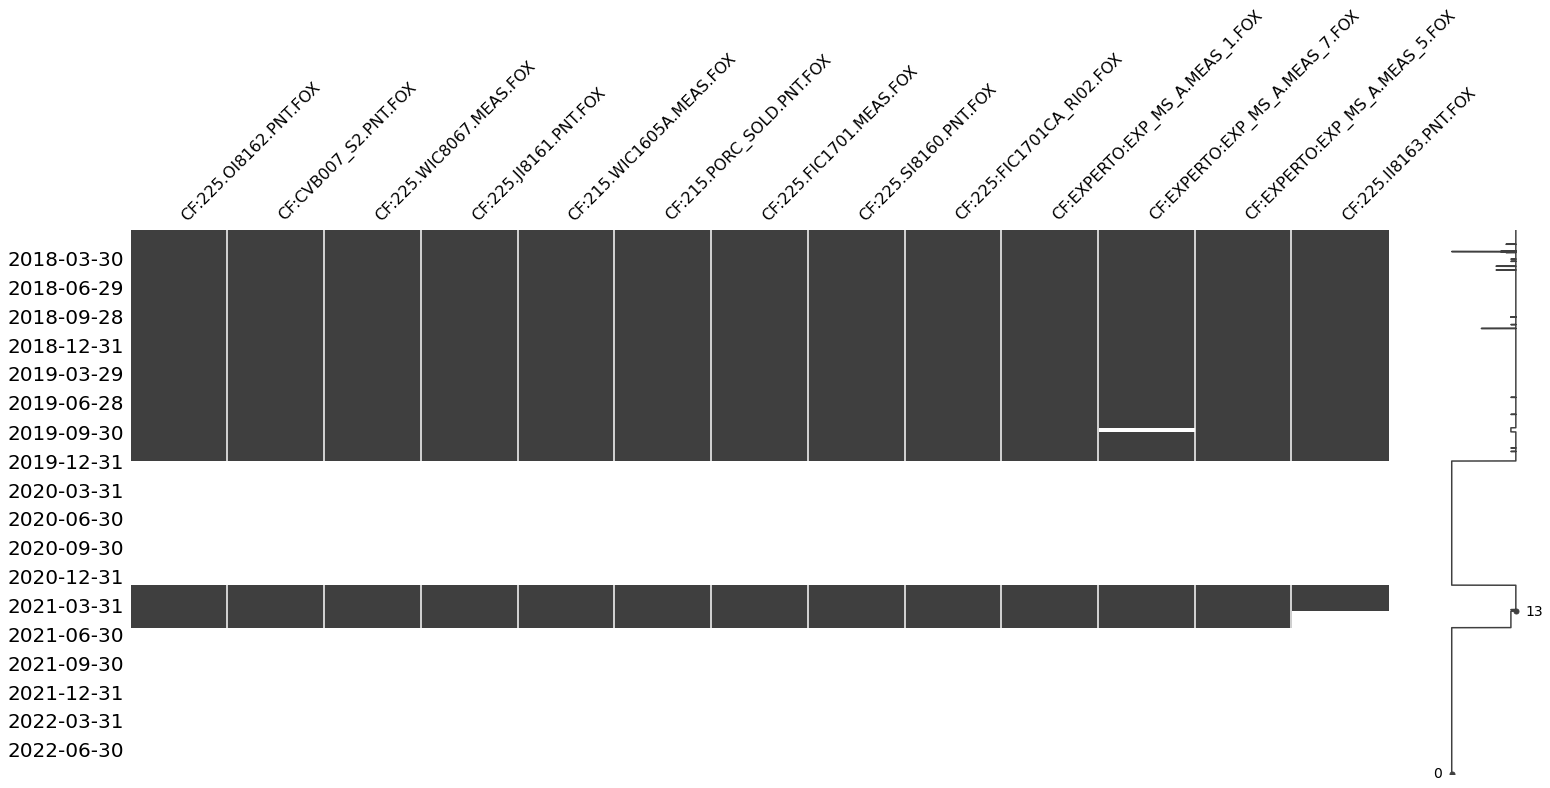

In [35]:
# Missings
msno.matrix(df_SAG,freq='BQ')

# Join de la data

In [36]:
consolidation=smart_merge(df_SAG,df_apc)
consolidation=smart_merge(df_granulometria,consolidation)
consolidation=smart_merge(df_dispatch,consolidation)
consolidation=smart_merge(df_apc_comments,consolidation)
consolidation.head()

,CF:EXPERTO.HAB_EXP.CO_1.FOX,Limitado por Límite Alto de Tonelaje,Optimizando tonelaje,Limitado por Peso,Limitado por Corriente Bobina,Limitado por torque espesador 2,Limitado por torque espesador 3,Limitado por Potencia Bolas 1,Limitado por Potencia Bolas 2,Limitado por Pebbles,...,CF:215.WIC1605A.MEAS.FOX,CF:215.PORC_SOLD.PNT.FOX,CF:225.FIC1701.MEAS.FOX,CF:225.SI8160.PNT.FOX,CF:225:FIC1701CA_RI02.FOX,CF:EXPERTO:EXP_MS_A.MEAS_1.FOX,CF:EXPERTO:EXP_MS_A.MEAS_7.FOX,CF:EXPERTO:EXP_MS_A.MEAS_5.FOX,CF:225.II8163.PNT.FOX,CF:CVB007_S2.PNT.FOX
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3847.009774,65.090716,2063.724810,9.063008,65.0,820.0,900.0,4350.0,3935.520368,63.702719
2018-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3872.996001,65.171210,2072.257994,9.062102,65.0,820.0,900.0,4350.0,3930.839200,62.920996
2018-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3879.211149,65.122192,2079.820066,9.062520,65.0,820.0,900.0,4350.0,3923.503230,62.847943
2018-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3894.792946,65.085609,2089.536865,9.062208,65.0,820.0,900.0,4350.0,3914.689267,63.369101
2018-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3959.416847,65.271563,2110.715057,9.062822,65.0,820.0,900.0,4350.0,3910.292390,63.409187


In [37]:
consolidation.shape

(2475480, 37)

<AxesSubplot:>

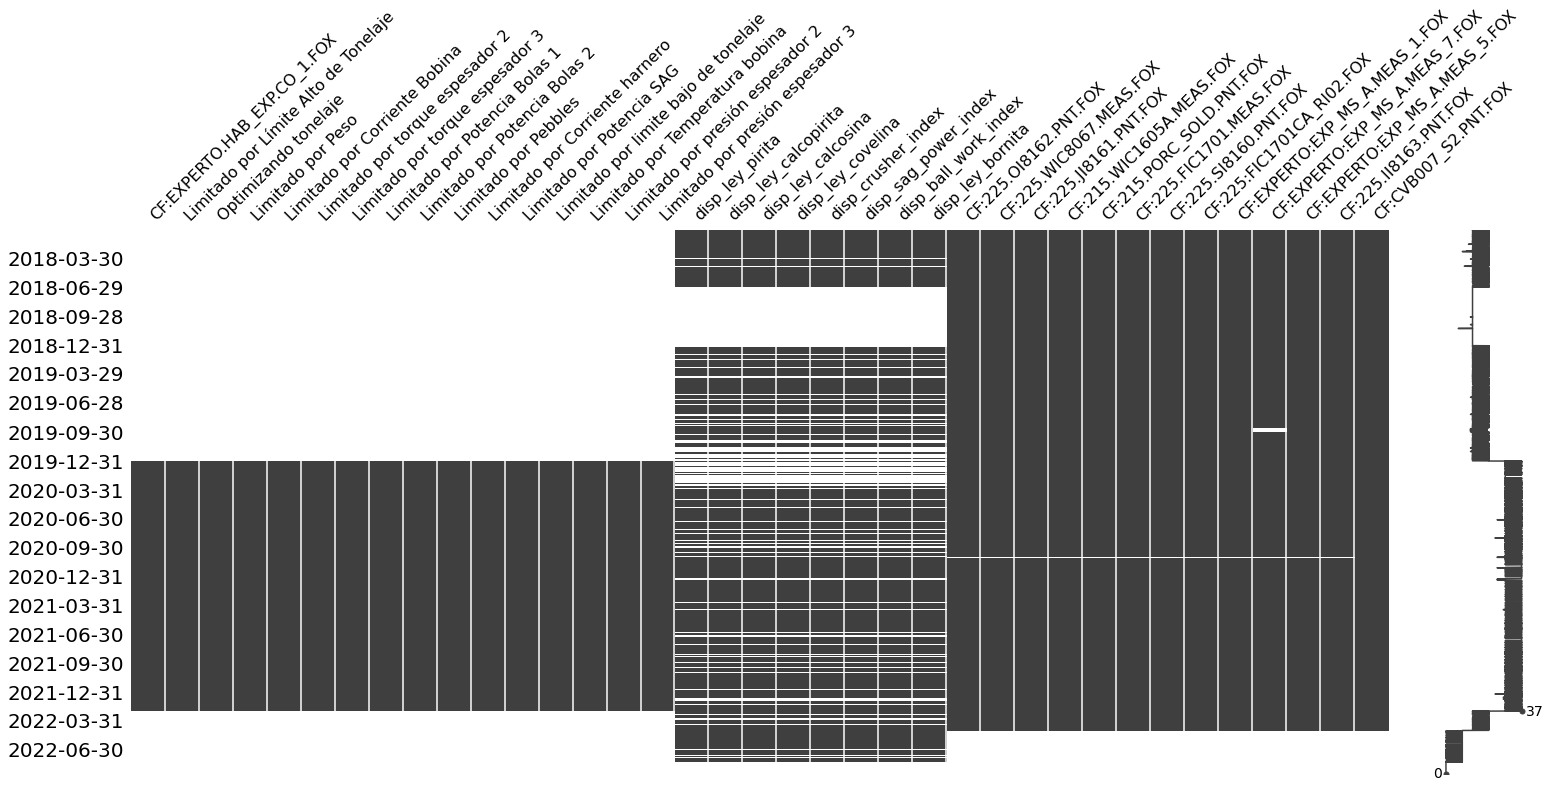

In [38]:
# Missings
msno.matrix(consolidation,freq='BQ')

# Save consolidation

In [39]:
# Se guarda en csv
consolidation.to_csv('../../data/consolidated data/consolidation_'+pd.to_datetime('today').strftime('%d%B%Y')+'.csv', index=True)

# Reporte Nans

## 2018

In [40]:
nons=pd.DataFrame()

In [41]:
raw2018=consolidation[("2018-01-01" <=consolidation.index) & (consolidation.index<="2018-12-31")].copy()

In [42]:
nons["% nans 2018"]=(raw2018.isnull().sum()/len(raw2018)*100).apply(lambda x: round(x,1))

<AxesSubplot:>

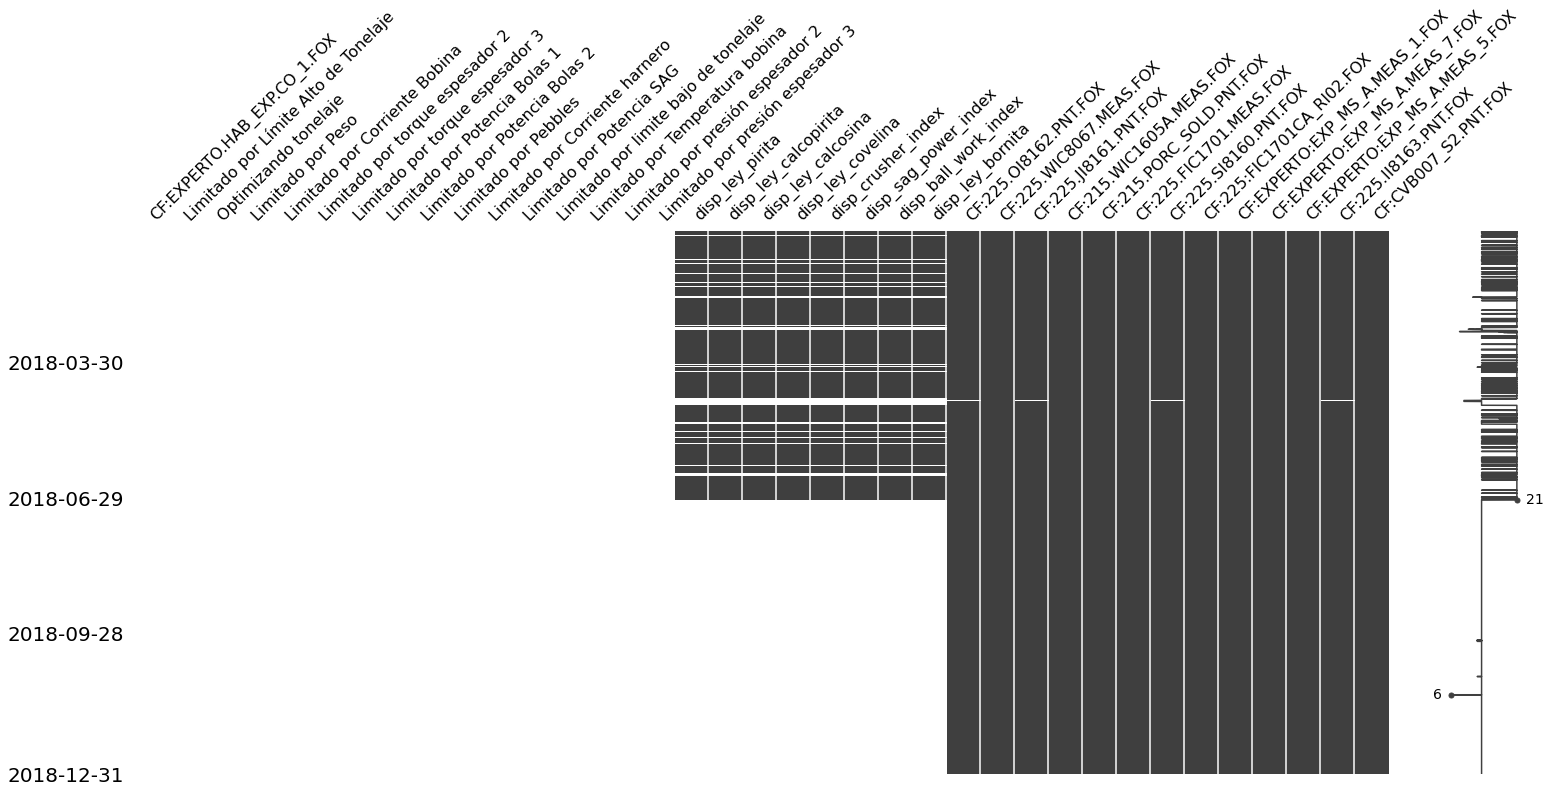

In [43]:
# Missings
msno.matrix(raw2018,freq='BQ')

## 2019


In [44]:
raw2019=consolidation[("2019-01-01" <=consolidation.index) & (consolidation.index<="2019-12-31")].copy()

In [45]:
nons["% nans 2019"]=(raw2019.isnull().sum()/len(raw2019)*100).apply(lambda x: round(x,1))

<AxesSubplot:>

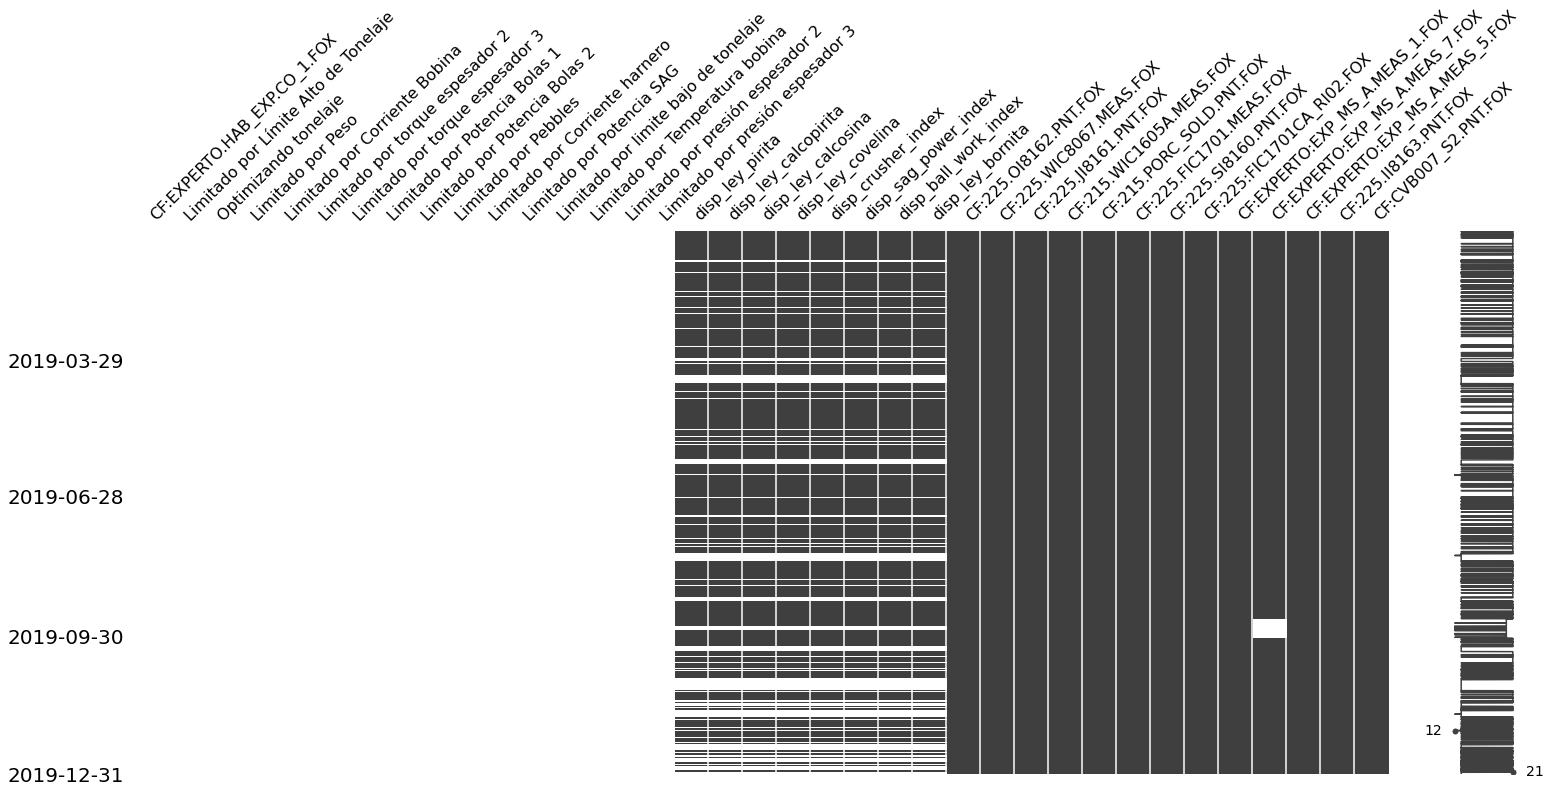

In [46]:
# Missings
msno.matrix(raw2019,freq='BQ')

## 2020


In [47]:
raw2020=consolidation[("2020-01-01" <=consolidation.index) & (consolidation.index<="2020-12-31")].copy()

In [48]:
nons["% nans 2020"]=(raw2020.isnull().sum()/len(raw2020)*100).apply(lambda x: round(x,1))

<AxesSubplot:>

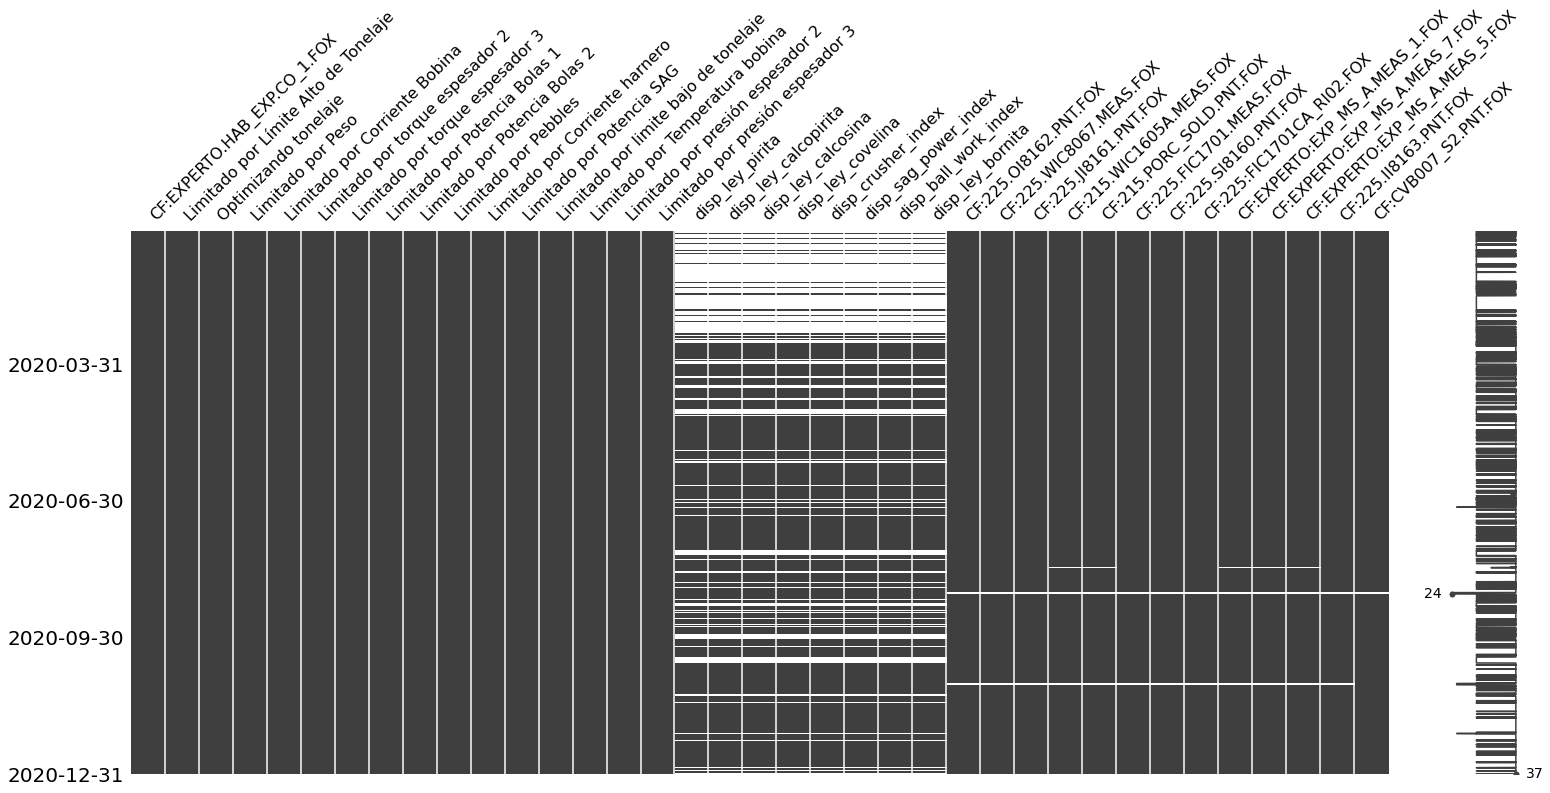

In [49]:
# Missings
msno.matrix(raw2020,freq='BQ')

## 2021


In [50]:
raw2021=consolidation[("2021-01-01" <=consolidation.index) & (consolidation.index<="2021-12-31")].copy()

In [51]:
nons["% nans 2021"]=(raw2021.isnull().sum()/len(raw2021)*100).apply(lambda x: round(x,1))

<AxesSubplot:>

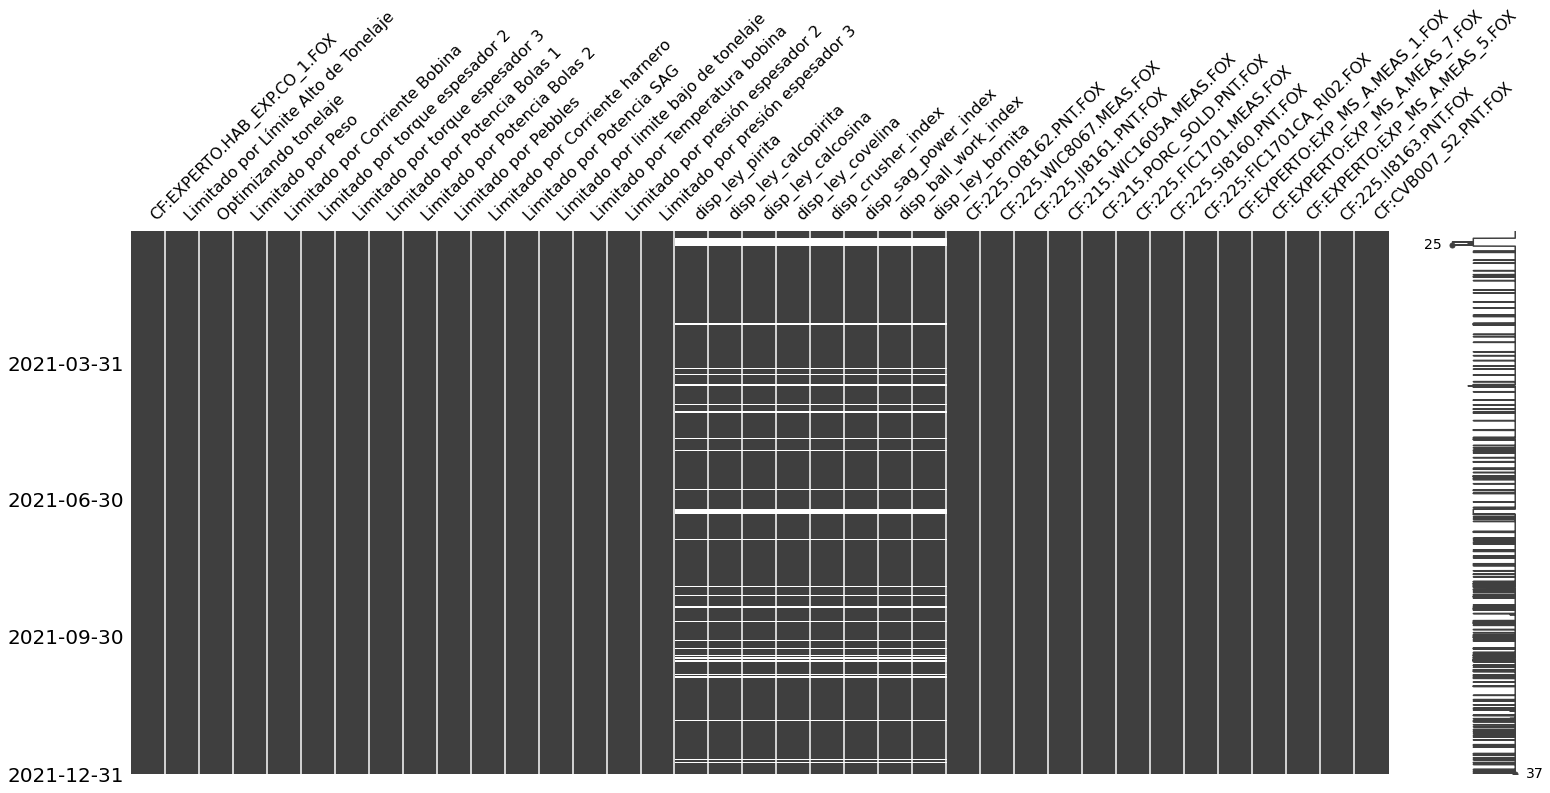

In [52]:
# Missings
msno.matrix(raw2021,freq='BQ')

# 2022

In [54]:
raw2022=consolidation[("2022-01-01" <=consolidation.index) & (consolidation.index<="2022-12-31")].copy()

In [55]:
nons["% nans 2022"]=(raw2022.isnull().sum()/len(raw2022)*100).apply(lambda x: round(x,1))

<AxesSubplot:>

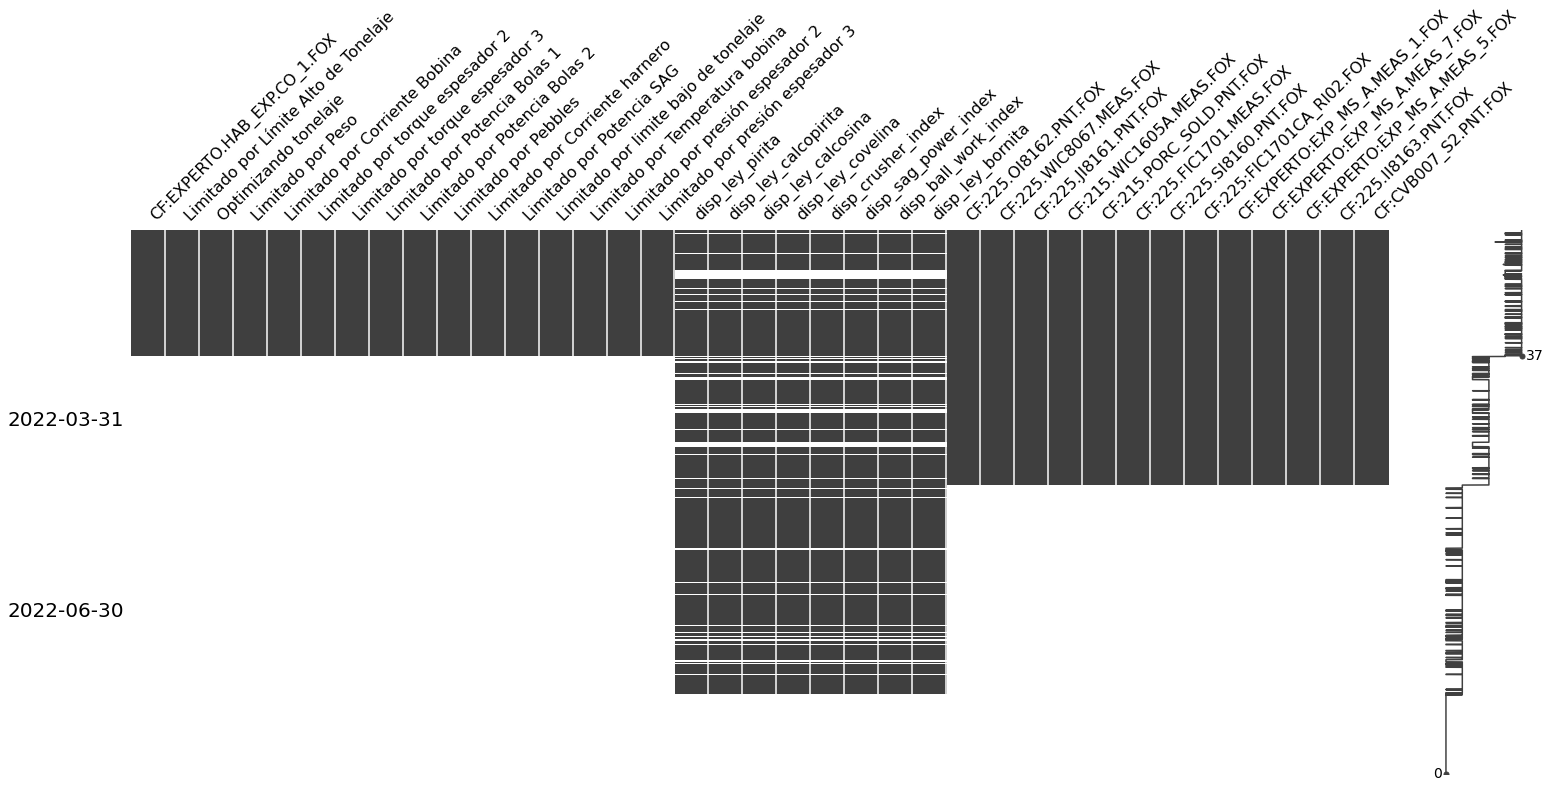

In [56]:
# Missings
msno.matrix(raw2022,freq='BQ')

In [57]:
# nons totales
nons["% nans total"]=(consolidation.isnull().sum()/len(consolidation)*100).apply(lambda x: round(x,1))

# Resumen valores nan

In [58]:
nons

,% nans 2018,% nans 2019,% nans 2020,% nans 2021,% nans 2022,% nans total
CF:EXPERTO.HAB_EXP.CO_1.FOX,100.0,100.0,0.0,0.0,76.8,54.0
Limitado por Límite Alto de Tonelaje,100.0,100.0,0.0,0.0,76.8,54.0
Optimizando tonelaje,100.0,100.0,0.0,0.0,76.8,54.0
Limitado por Peso,100.0,100.0,0.0,0.0,76.8,54.0
Limitado por Corriente Bobina,100.0,100.0,0.0,0.0,76.8,54.0
Limitado por torque espesador 2,100.0,100.0,0.0,0.0,76.8,54.0
Limitado por torque espesador 3,100.0,100.0,0.0,0.0,76.8,54.0
Limitado por Potencia Bolas 1,100.0,100.0,0.0,0.0,76.8,54.0
Limitado por Potencia Bolas 2,100.0,100.0,0.0,0.0,76.8,54.0
Limitado por Pebbles,100.0,100.0,0.0,0.0,76.8,54.0
